In [1]:
%matplotlib inline

In [2]:


import matplotlib as mpl
import matplotlib.pyplot as plt
from math import pi,e


In [3]:
from scipy.io import loadmat
from scipy.io.arff import loadarff
import numpy as np
import pandas as pd
from collections import OrderedDict


In [50]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import precision_recall_curve, roc_curve, average_precision_score, auc, make_scorer
from sklearn.metrics import f1_score,accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.externals.joblib import Parallel, delayed

In [5]:
import seaborn as sns
sns.set(font_scale=1.5)

# Using PCA for detection

In [6]:
data = loadmat('data/cardio.mat')

In [7]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])

In [8]:
X = data['X']
y = data['y']

In [9]:
X.shape, y.shape

((1831, 21), (1831, 1))

In [10]:
y = y.squeeze()

In [11]:
scaler = StandardScaler()

In [12]:
X = scaler.fit_transform(X)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

In [14]:
len(X_train)

1647

In [15]:
def score(a, b):
    """Normalized differnece of squares between a and b."""

    loss = np.sum((a-b)**2, axis=1)
    loss = (loss-loss.min())/(loss.max() - loss.min())
    return loss

In [16]:
def fit(n, X):
    pca = PCA(n_components=n)
    X_pca = pca.fit_transform(X)
    X_pca_inverse = pca.inverse_transform(X_pca)
    y_score = score(X, X_pca_inverse)
    return (n, y_score)

In [17]:
search = Parallel(n_jobs=-1)(delayed(fit)(n, X_train) for n in range(2,X.shape[1]))

In [18]:
scores =  np.array([(n, average_precision_score(y_train, y_score)) for (n, y_score) in search])

In [19]:
best = max(scores, key=lambda x: x[1])
best

array([2.        , 0.40469961])

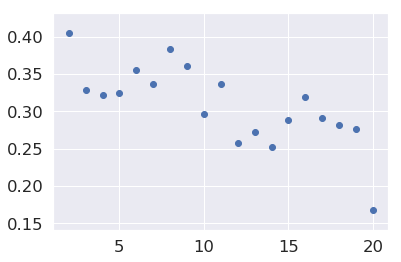

In [20]:
plt.scatter(scores[:, 0], scores[:, 1])
pass

In [21]:
n = int(best[0])
n, y_score = fit(n, X_test)

In [22]:
average_precision_score(y_test, y_score)

0.6881820425316556

In [23]:
df = pd.DataFrame(dict(score=y_score, y=y_test))

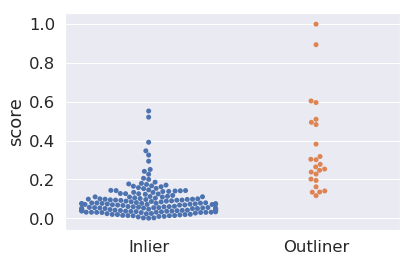

In [24]:
g = sns.swarmplot(data=df, x='y', y='score')
g.set_xticklabels(['Inlier', 'Outliner'])
g.set_xlabel('')
pass

In [25]:
precision, recall, thresholds = precision_recall_curve(y_test, y_score)

# Visualizing data

In [26]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

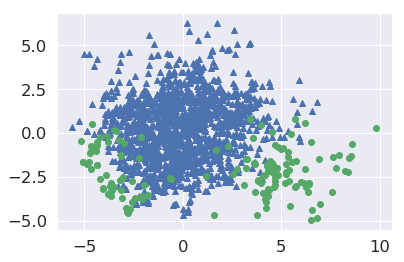

In [27]:
plt.plot(X_pca[y_train == 0,0],X_pca[y_train==0,1],'b^')
plt.plot(X_pca[y_train == 1,0],X_pca[y_train==1,1],'go')

# Gaussian Distribution

In [159]:
data = loadmat('data/cardio.mat')

In [160]:
X = data['X']
y = data['y']

In [161]:
scaler = StandardScaler()

In [162]:
X = scaler.fit_transform(X)

In [163]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

In [164]:
def estimateGaussian(X):
    mu = np.sum(X,axis = 0)/X.shape[0]
    sigma2 = np.sum((X-mu)**2,axis = 0)/X.shape[0] 
    return mu,sigma2

In [165]:
def multivariateGaussian(X,mu,sigma2):
    sigma2 = np.diag(sigma2)
    k = len(mu)
    p = (2*pi)**(-k/2)*np.linalg.det(sigma2)**(-0.5)*np.exp(-0.5*((((X-mu))@np.linalg.inv(sigma2))@(X-mu).T))
    return np.diag(p)

In [166]:
def selectThresholds(y,p):
    bestEpsilon = 0
    bestF1 = 0
    f1_score = 0
    stepsize = (max(p)-min(p))/10000
    for i in np.arange(min(p),max(p),stepsize):
        prediction = (p < i).astype(int)
        prediction = prediction.reshape(prediction.shape[0],1)
        fp = np.sum((prediction == 1) * (y == 0))

        fn = np.sum((prediction == 0) * (y == 1))
        tp = np.sum((prediction == 1) * (y == 1))

        prec = tp / (tp + fp)
        rec = tp / (tp + fn)
        
        f1_score = 2 * prec * rec / (prec + rec)
        if f1_score > bestF1:
            bestF1 = f1_score
            bestEpsilon = i
    return bestEpsilon,bestF1

    

In [167]:
X_normally = X_train[np.where(y_train == 0)[0]]
y_normally = y_train[np.where(y_train == 0)[0]]
X_anormally = X_train[np.where(y_train == 1)[0]]
y_anormally = y_train[np.where(y_train == 1)[0]]

In [175]:
mu,sigma2 = estimateGaussian(X_train)


In [176]:
p = multivariateGaussian(X_train,mu,sigma2)

In [177]:
epsilon,F1= selectThresholds(y_train,p)
epsilon,F1

/home/huuthieu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in long_scalars
  


(8.161035678916865e-14, 0.5277310924369748)

In [178]:
# epsilon = p.mean() - 3*p.std()
# epsilon

In [179]:
p_test = multivariateGaussian(X_test,mu,sigma2)

In [180]:
pre = p_test < epsilon

In [181]:
from sklearn.metrics import f1_score
f1_score(pre,y_test),accuracy_score(pre,y_test)

(0.45454545454545453, 0.8043478260869565)

# Gaussian Mixer Models

In [98]:
from scipy.stats import multivariate_normal

In [158]:
class GMM:
    def __init__(self, k, max_iter=5):
        self.k = k
        self.max_iter = int(max_iter)

    def initialize(self, X):
        self.shape = X.shape
        self.n, self.m = self.shape

        self.phi = np.full(shape=self.k, fill_value=1/self.k)
        self.weights = np.full( shape=self.shape, fill_value=1/self.k)
        
        random_row = np.random.randint(low=0, high=self.n, size=self.k)
        self.reg_cov = 1e-6*np.identity(self.m)
        self.mu = [  X[row_index,:] for row_index in random_row ]
        self.sigma = [ (np.cov(X.T)+self.reg_cov)  for _ in range(self.k) ] 

    def e_step(self, X):
        # E-Step: update weights and phi holding mu and sigma constant
        self.weights = self.predict_proba(X)
        self.phi = self.weights.mean(axis=0)
    
    def m_step(self, X):
        # M-Step: update mu and sigma holding phi and weights constant
        for i in range(self.k):
            weight = self.weights[:, [i]]
            total_weight = weight.sum()
            self.mu[i] = (X * weight).sum(axis=0) / total_weight
            self.sigma[i] = np.cov(X.T, 
                aweights=(weight/total_weight).flatten(), 
                bias=True) + self.reg_cov

    def fit(self, X):
        self.initialize(X)
        
        for iteration in range(self.max_iter):
            self.e_step(X)
            self.m_step(X)
            
    def predict_proba(self, X):
        likelihood = np.zeros( (self.n, self.k) )
        for i in range(self.k):
            distribution = multivariate_normal(
                mean=self.mu[i], 
                cov=self.sigma[i])
            likelihood[:,i] = distribution.pdf(X)
#             likelihood[:,i] = multivariateGaussian(X,self.mu[i],self.sigma[i])
        
        numerator = likelihood * self.phi
        denominator = numerator.sum(axis=1)[:, np.newaxis]
        weights = numerator / denominator
        return weights
    
    def predict(self, X):
        weights = self.predict_proba(X)
        return np.argmax(weights, axis=1)

In [159]:
data = loadmat('data/cardio.mat')
X = data['X']
y = data['y']

In [160]:
scaler = StandardScaler()

In [161]:
X = scaler.fit_transform(X)

In [162]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

In [163]:
X_normally = X_train[np.where(y_train == 0)[0]]
y_normally = y_train[np.where(y_train == 0)[0]]
X_anormally = X_train[np.where(y_train == 1)[0]]
y_anormally = y_train[np.where(y_train == 1)[0]]

In [178]:
gmm = GMM(k=1, max_iter=10)
gmm.fit(X_train)
pre = gmm.predict(X_train)

# GMM with Sklearn for anomaly detection

In [119]:
data = loadmat('data/cardio.mat')
X = data['X']
y = data['y']

In [120]:
scaler = StandardScaler()

In [121]:
X = scaler.fit_transform(X)

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

In [123]:
X_normally = X_train[np.where(y_train == 0)[0]]
y_normally = y_train[np.where(y_train == 0)[0]]
X_anormally = X_train[np.where(y_train == 1)[0]]
y_anormally = y_train[np.where(y_train == 1)[0]]

In [124]:
from sklearn.mixture import GaussianMixture

In [125]:
gmm = GaussianMixture(n_components=1)

In [188]:
gmm.fit(X_normally)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=1, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [183]:
score = gmm.score_samples(X_train)

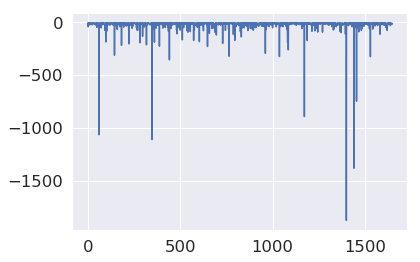

In [128]:
plt.plot(score)

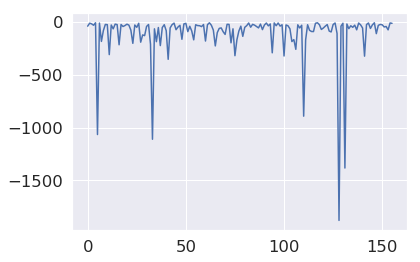

In [129]:
anomaly_score = score[np.where(y_train == 1)[0]]
plt.plot(anomaly_score)

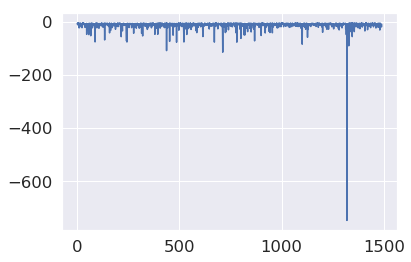

In [130]:
nomaly_score = score[np.where(y_train == 0)[0]]
plt.plot(nomaly_score)

In [184]:
epsilon,F1= selectThresholds(y_train,score)
epsilon,F1

/home/huuthieu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in long_scalars
  


(-18.92562493089602, 0.5135135135135135)

In [185]:
test_score = gmm.score_samples(X_test)
pre = (test_score < epsilon).astype(int)

In [186]:
f1_score(pre,y_test)

0.41666666666666663

In [187]:
accuracy_score(pre,y_test)

0.8478260869565217